In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

import sklearn.metrics

# Generate Data

### Seminar example

In [2]:
sem_ground_truth = np.array([0, 1, 0, 0, 1, 1])
sem_predict_probabilities = np.array([0.14, 0.23, 0.39, 0.52, 0.73, 0.9 ])

### Random classifier

In [3]:
def random_classifier(length : int, assurance : float = 0.5):
    prob = np.random.rand(length)
    pred = np.random.choice([0,1], length)
    return pred,prob

a = random_classifier(100)
print(a[0].mean())
print(a[1].mean())
# print(a)

0.5
0.5493179314398835


In [4]:
rand_ground_truth,rand_predict_probabilities = random_classifier(1000, 0.9)
# rand_predict_probabilities = np.full(rand_ground_truth.shape, 0.5)

### Perfect classifier 

### sklearn example of SVC
[source](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

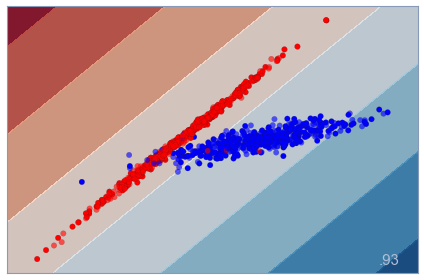

In [5]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

X, y = make_classification(
    n_samples = 1000, n_features=2, n_redundant=0, n_informative=2,
    random_state=1587, n_clusters_per_class=1)

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42)

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
ax = plt.subplot(1, 1, 1)
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
# Plot the testing points
ax.scatter(
    X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

clf =  SVC(kernel="linear", C=0.025)
# clf =  SVC(kernel="linear", C=0.25)
clf.probability = True
clf.fit(X_train, y_train)
lin_probabilities = np.max(clf.predict_proba(X_test), axis=1)
score = clf.score(X_test, y_test)
DecisionBoundaryDisplay.from_estimator(
    clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
)

# Plot the training points
ax.scatter(
    X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
)
# Plot the testing points
ax.scatter(
    X_test[:, 0],
    X_test[:, 1],
    c=y_test,
    cmap=cm_bright,
    edgecolors="k",
    alpha=0.6,
)

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
ax.text(
    x_max - 0.3,
    y_min + 0.3,
    ("%.2f" % score).lstrip("0"),
    size=15,
    horizontalalignment="right",
)

plt.tight_layout()
plt.show()

In [6]:
lin_predict_probabilities = lin_probabilities
lin_ground_truth = y_test

### Stack data for convinience

In [7]:
ground_truth = [sem_ground_truth, rand_ground_truth, lin_ground_truth]
probabilities = [sem_predict_probabilities, rand_predict_probabilities, lin_predict_probabilities]
names = ['Seminar example','Random classifier','Linear SVC']
# print(sorted(lin_predict_probabilities))

### AUC implementation

In [8]:
def AUC(x : np.ndarray, precision : np.ndarray):
    assert(precision.shape == x.shape)
#     descending order
    if (np.all(x[:-1] >= x[1:])):
        I = np.arange(0, len(precision)-1)
        return np.sum((precision[I]+precision[I+1])*(x[I]-x[I+1])/2)
    elif (np.all(x[:-1] <= x[1:])):
#     ascending order
        I = np.arange(1, len(precision))
        return np.sum((precision[I]+precision[I-1])/2*(x[I]-x[I-1]))
    else:
        raise Exception("x must be an array-like in ascending or descending order")

### PR curve implementation

In [11]:
def PR_curve(ground_truth : np.ndarray, predict_probabilities):
    assert(ground_truth.shape == predict_probabilities.shape)
    precision_list = []
    recall_list = []
    thresholds = predict_probabilities
#     print(np.unique(thresholds).shape[0])
    if (np.unique(thresholds).shape[0]<2):
        thresholds = np.append(thresholds, [0.0])
    thresholds = np.append(thresholds, [1.0])        
    thresholds.sort()
    for threshold in thresholds:
        predict = (predict_probabilities>threshold)*1

        TP = np.count_nonzero((predict == 1)*(ground_truth == 1))
        TN = np.count_nonzero((predict == 0)*(ground_truth == 0))
        FP = np.count_nonzero((predict == 1)*(ground_truth == 0))
        FN = np.count_nonzero((predict == 0)*(ground_truth == 1))
    
        
        precision = TP/(TP+FP+1e-12)
        recall = TP/(TP+FN)
        
        precision_list.append(precision)
        recall_list.append(recall)
        
    precision_arr = np.array(precision_list)
    recall_arr = np.array(recall_list)
    return precision_arr, recall_arr, predict

### PR curve in comparison with sklearn PR curve

Seminar example
	AUC        : 0.6833333333328758
	AUC sklearn: 0.8500000000000001
Random classifier
	AUC        : 0.5134413225297061
	AUC sklearn: 0.5144413225297124
Linear SVC
	AUC        : 0.8687040875122324
	AUC sklearn: 0.9182307196867414


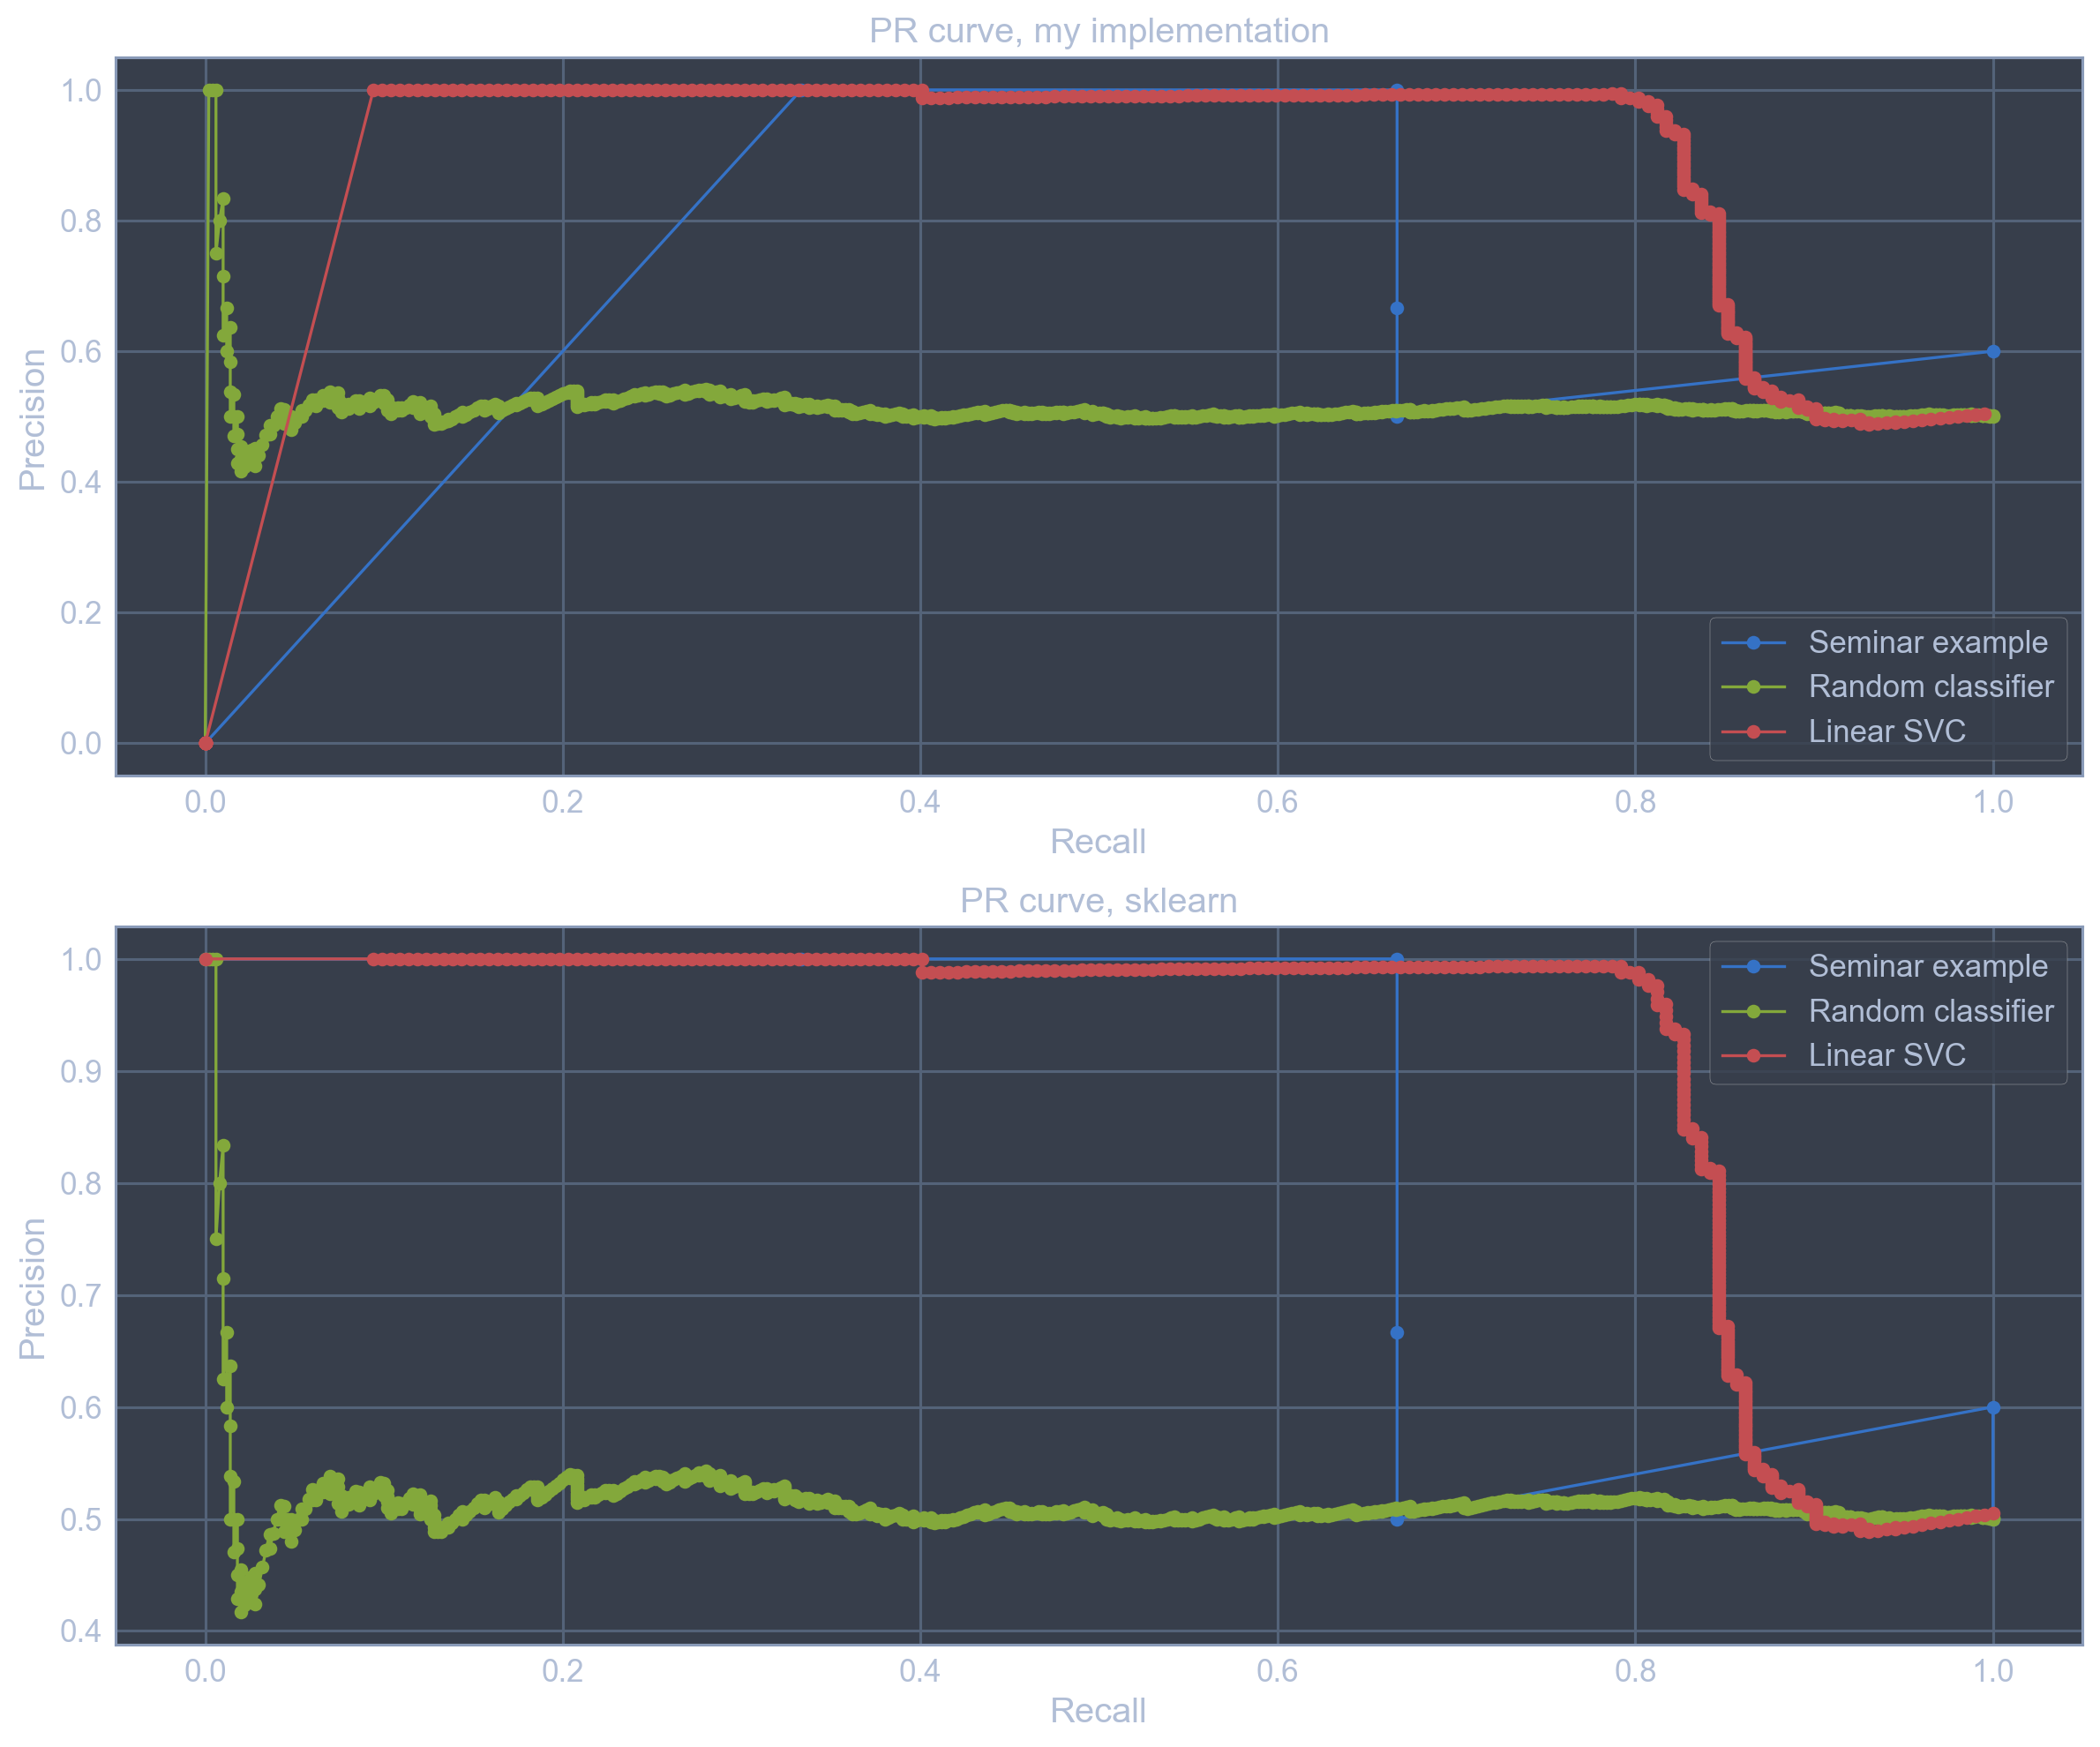

In [12]:
from sklearn.metrics import precision_recall_curve

fig, axs = plt.subplots(2, 1, figsize=(12,10), dpi=200)

for (gt, prob, name) in zip(ground_truth, probabilities, names):
    precision, recall, thresholds = PR_curve(gt, prob)
    precision2, recall2, thresholds2 = precision_recall_curve(gt, prob)
    axs[0].set_title("PR curve, my implementation")
    axs[0].set_xlabel("Recall")
    axs[0].set_ylabel("Precision")
    axs[0].plot(recall, precision, '-o', label = name)
    axs[0].legend()
    
    axs[1].set_title("PR curve, sklearn")
    axs[1].set_xlabel("Recall")
    axs[1].set_ylabel("Precision")
    axs[1].plot(recall2, precision2, '-o',  label = name)
    axs[1].legend()
    print(f"{name}")
    print(f"\tAUC        : {AUC(recall, precision)}")
    print(f"\tAUC sklearn: {sklearn.metrics.auc(recall2, precision2)}")
plt.tight_layout()

plt.show()


### ROC curve implementation

In [13]:
def ROC_curve(ground_truth, predict):
    assert(ground_truth.shape == predict.shape)
    tpr_list = []
    fpr_list = []
    thresholds = np.append(predict, np.max(predict)+1.0)
    thresholds.sort()
    thresholds = thresholds[::-1]
    for threshold in thresholds:
        prediction = (predict>=threshold)*1

        TP = np.count_nonzero((prediction == 1)*(ground_truth == 1))
        TN = np.count_nonzero((prediction == 0)*(ground_truth == 0))
        FP = np.count_nonzero((prediction == 1)*(ground_truth == 0))
        FN = np.count_nonzero((prediction == 0)*(ground_truth == 1))
        
        TPR = TP/(TP+FN)
        FPR = FP/(FP+TN)
        
        tpr_list.append(TPR)
        fpr_list.append(FPR)
    tpr_arr = np.array(tpr_list)
    fpr_arr = np.array(fpr_list)
    return fpr_arr, tpr_arr, thresholds

### ROC curve in comparison with sklearn ROC curve

Seminar example
	AUC        : 0.7777777777777778
	AUC sklearn: 0.7777777777777778
Random classifier
	AUC        : 0.517216
	AUC sklearn: 0.517216
Linear SVC
	AUC        : 0.8570107010701069
	AUC sklearn: 0.857010701070107


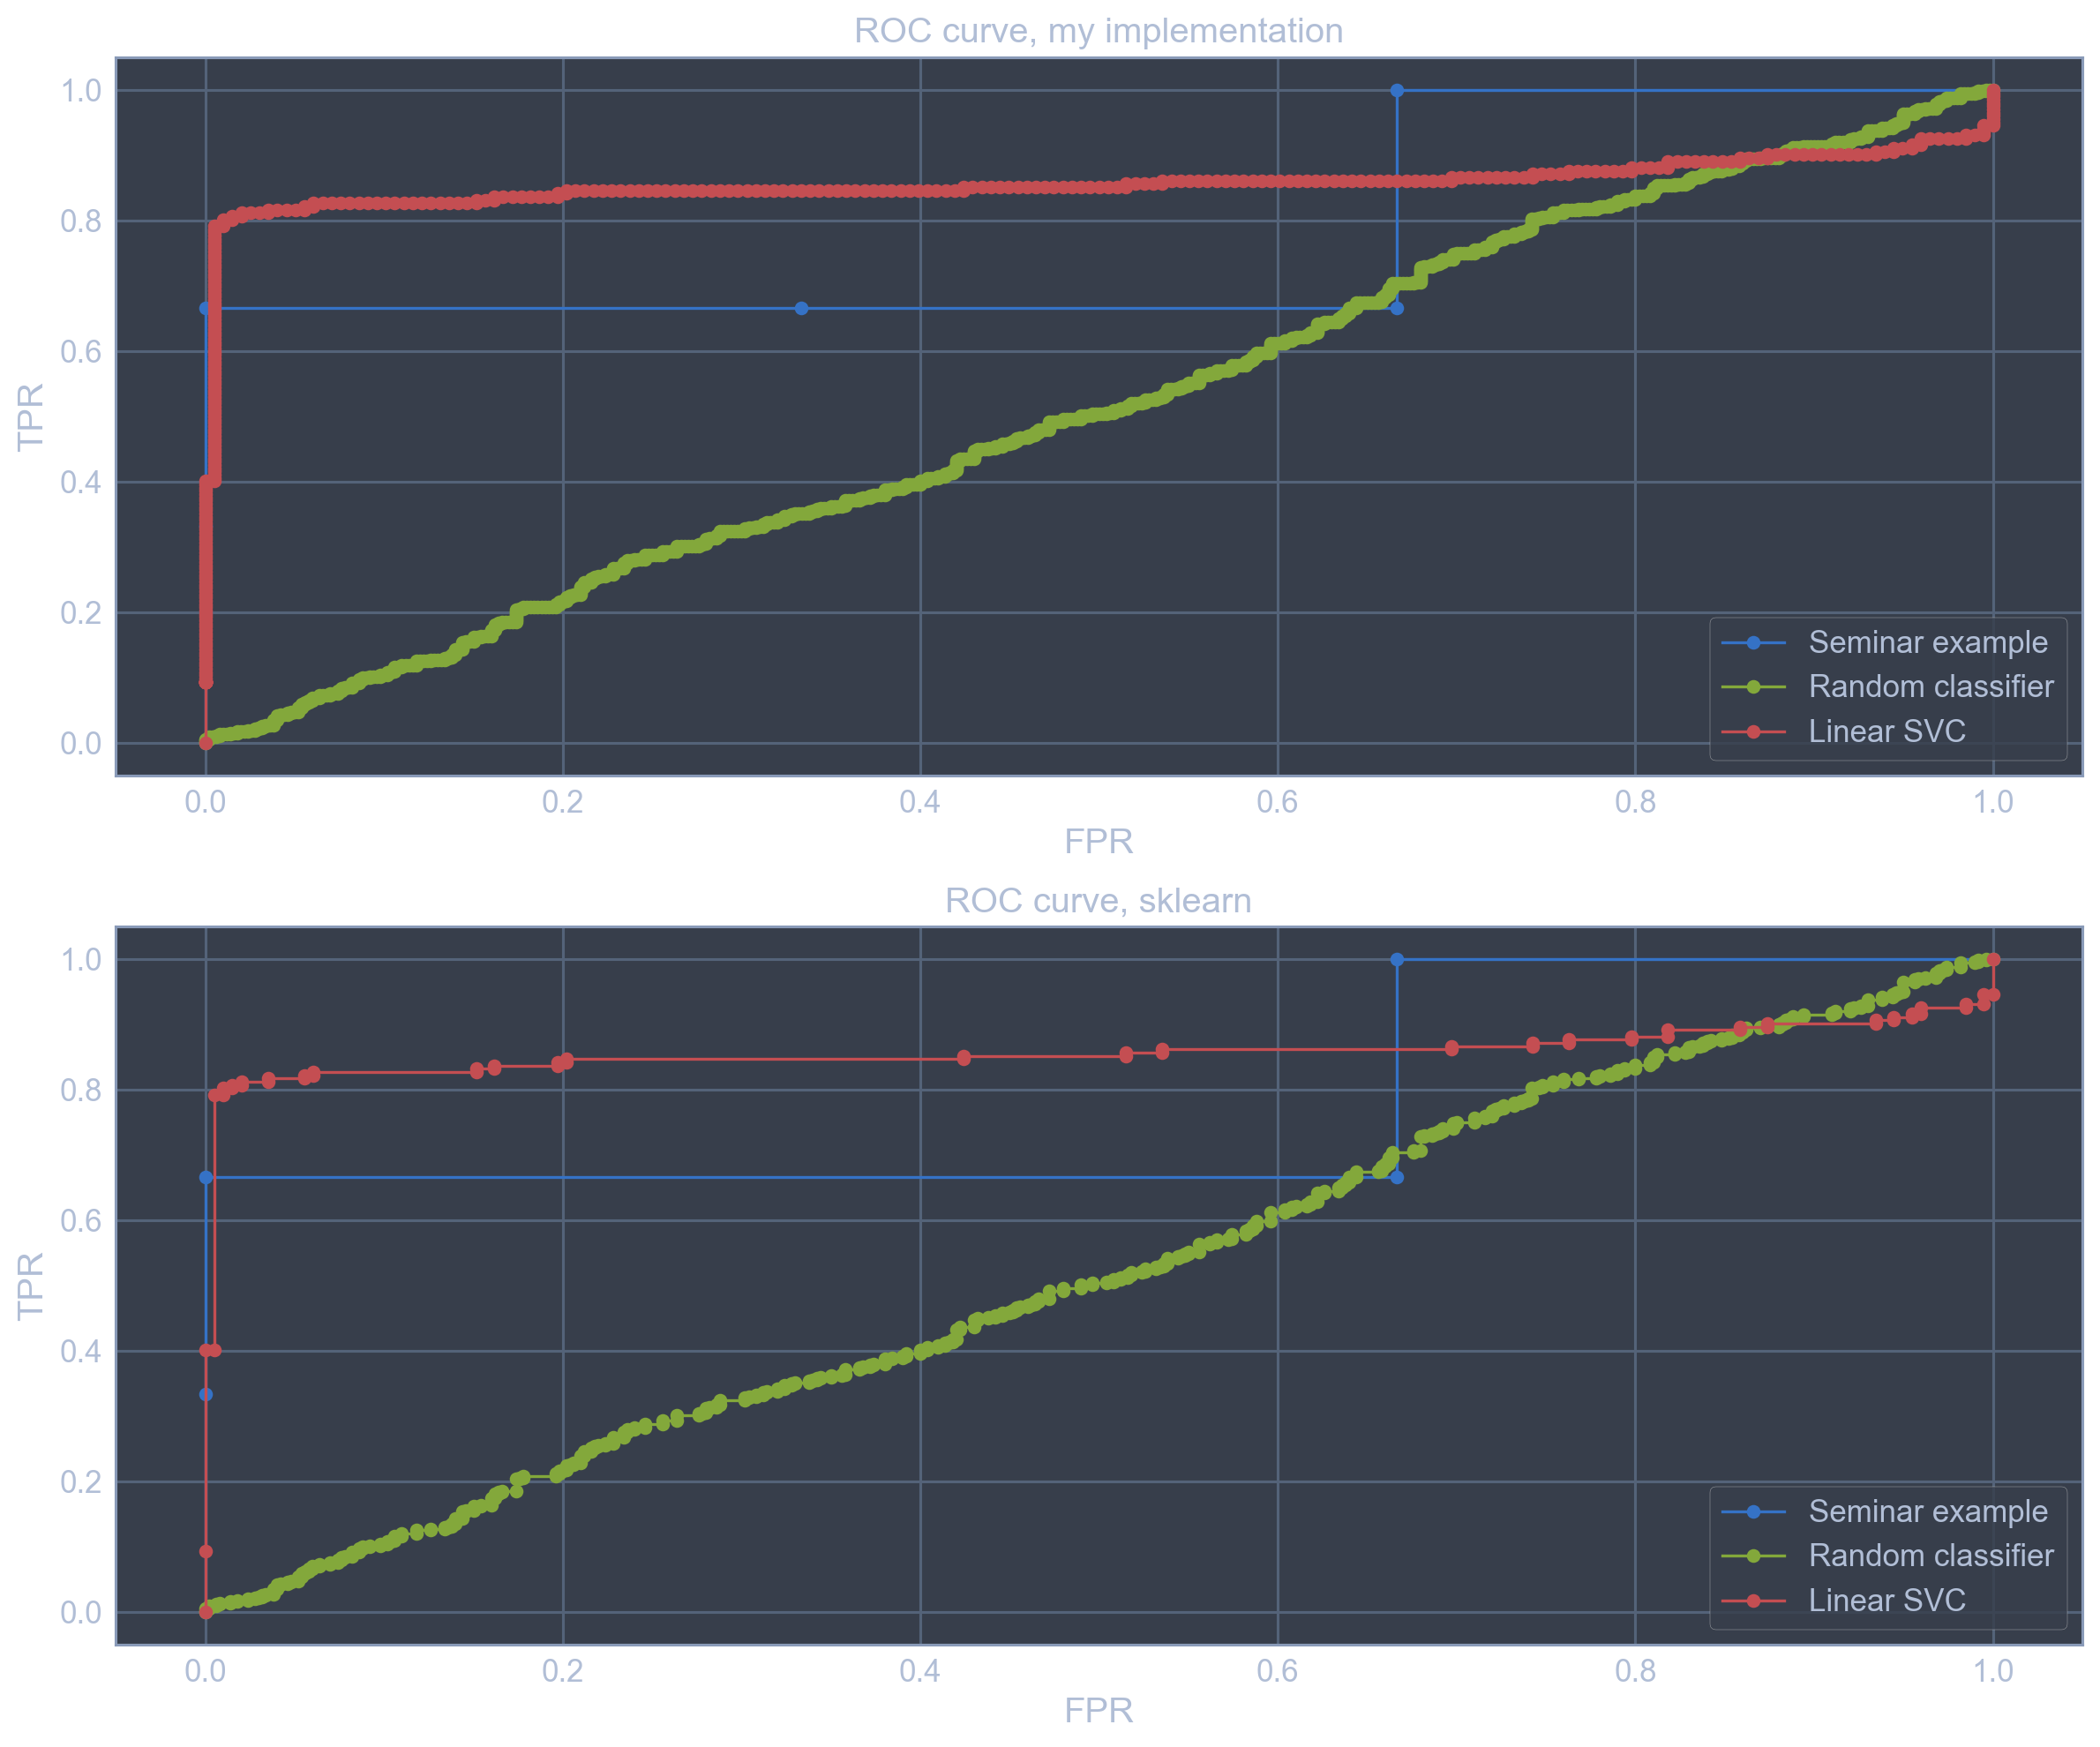

In [14]:
from sklearn.metrics import roc_curve
fig, axs = plt.subplots(2, 1, figsize=(12,10), dpi=200)
for (gt, prob, name) in zip(ground_truth, probabilities, names):
    fpr, tpr, thresholds = ROC_curve(gt, prob)
    fpr2, tpr2, thresholds2 = roc_curve(gt, prob)
       
    axs[0].set_title("ROC curve, my implementation")
    axs[0].set_xlabel("FPR")
    axs[0].set_ylabel("TPR")
    axs[0].plot(fpr, tpr, '-o', label = name)
    axs[0].legend()
    
    axs[1].set_title("ROC curve, sklearn")
    axs[1].set_xlabel("FPR")
    axs[1].set_ylabel("TPR")
    axs[1].plot(fpr2, tpr2, '-o',  label = name)
    axs[1].legend()
    print(f"{name}")
    print(f"\tAUC        : {AUC(fpr, tpr)}")
    print(f"\tAUC sklearn: {sklearn.metrics.auc(fpr2, tpr2)}")
plt.tight_layout()

plt.show()

In [16]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)

tpr = tp/(tp+fn)
fpr = fp/(fp+tn)


NameError: name 'tp' is not defined